In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import CelebA
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import requests
from torchvision.models import inception_v3
from torch.distributions import MultivariateNormal
import seaborn as sns
import scipy
import numpy as np
import pandas as pd

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    '''
    return torch.randn(n_samples, z_dim, device=device)

# Loading the Pre-trained Model

In [ ]:
z_dim = 64
image_size = 299
device = 'cuda'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = CelebA(".", download=True, transform=transform)

In [6]:
gen = Generator(z_dim).to(device)
gen.load_state_dict(torch.load(f"/content/gdrive/MyDrive/Colab Notebooks/16 - GANs/models/pretrained_celeba.pth", map_location=torch.device(device))["gen"])
gen = gen.eval()

In [ ]:
# inception model with ImageNet
inception_model = inception_v3(pretrained=False, init_weights=True)
inception_model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
inception_model.to(device)
inception_model = inception_model.eval()

In [8]:
# replace the final fully-connected (fc) layer with an identity function layer to cut off the classification
inception_model.fc = torch.nn.Identity()

In [9]:
test_identity_noise = torch.randn(100, 100)
inception_model.fc(test_identity_noise).shape

torch.Size([100, 100])

# Fréchet Inception Distance

Fréchet Inception Distance (FID) was proposed as an improvement over Inception Score and still uses the Inception-v3 network as part of its calculation. However, instead of using the classification labels of the Inception-v3 network, it uses the output from an earlier layer—the layer right before the labels. This is often called the feature layer. 

To get the feature layer of a convolutional neural network, you can replace the final fully connected layer with an identity layer that simply returns whatever input it received, unchanged. This essentially removes the final classification layer and leaves you with the intermediate outputs from the layer before.


## Fréchet Distance 
Fréchet distance uses the values from the feature layer for two sets of images, say reals and fakes, and compares different statistical properties between them to see how different they are. Specifically, Fréchet distance finds the shortest distance needed to walk along two lines, or two curves, simultaneously. The most intuitive explanation of Fréchet distance is as the "minimum leash distance" between two points. Imagine yourself and your dog, both moving along two curves. If you walked on one curve and your dog, attached to a leash, walked on the other at the same pace, what is the least amount of leash that you can give your dog so that you never need to give them more slack during your walk? Using this, the Fréchet distance measures the similarity between these two curves.

The basic idea is similar for calculating the Fréchet distance between two probability distributions. You'll start by seeing what this looks like in one-dimensional, also called univariate, space.


## Univariate Fréchet Distance
You can calculate the distance between two normal distributions $X$ and $Y$ with means $\mu_X$ and $\mu_Y$ and standard deviations $\sigma_X$ and $\sigma_Y$, as:

$$d(X,Y) = (\mu_X-\mu_Y)^2 + (\sigma_X-\sigma_Y)^2 $$

## Multivariate Fréchet Distance
**Covariance**

To find the Fréchet distance between two multivariate normal distributions, you first need to find the covariance instead of the standard deviation. The covariance, which is the multivariate version of variance (the square of standard deviation), is represented using a square matrix where the side length is equal to the number of dimensions. Since the feature vectors you will be using have 2048 values/weights, the covariance matrix will be 2048 x 2048. But for the sake of an example, this is a covariance matrix in a two-dimensional space:

$\Sigma = \left(\begin{array}{cc} 
1 & 0\\ 
0 & 1
\end{array}\right)
$

The value at location $(i, j)$ corresponds to the covariance of vector $i$ with vector $j$. Since the covariance of $i$ with $j$ and $j$ with $i$ are equivalent, the matrix will always be symmetric with respect to the diagonal. The diagonal is the covariance of that element with itself. In this example, there are zeros everywhere except the diagonal. That means that the two dimensions are independent of one another, they are completely unrelated.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


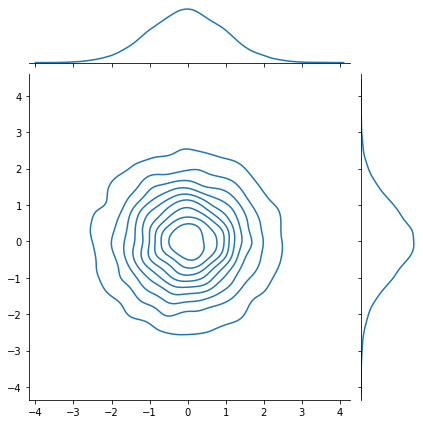

In [10]:
# Center the mean at the origin
mean = torch.Tensor([0, 0]) 
# This matrix shows independence - there are only non-zero values on the diagonal
covariance = torch.Tensor([[1, 0], [0, 1]])
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


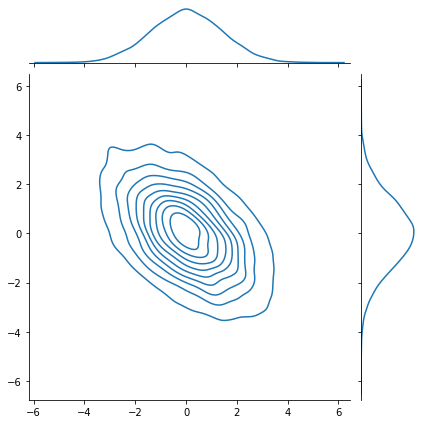

In [11]:
mean = torch.Tensor([0, 0])
covariance = torch.Tensor([[2, -1], [-1, 2]])
covariant_dist = MultivariateNormal(mean, covariance)
samples = covariant_dist.sample((10000,))
res = sns.jointplot(samples[:, 0], samples[:, 1], kind="kde")
plt.show()

**Formula**

Based on the paper, "[The Fréchet distance between multivariate normal distributions](https://core.ac.uk/reader/82269844)" by Dowson and Landau (1982), the Fréchet distance between two multivariate normal distributions $X$ and $Y$ is:

$d(X, Y) = \Vert\mu_X-\mu_Y\Vert^2 + \mathrm{Tr}\left(\Sigma_X+\Sigma_Y - 2 \sqrt{\Sigma_X \Sigma_Y}\right)$

Similar to the formula for univariate Fréchet distance, you can calculate the distance between the means and the distance between the standard deviations. However, calculating the distance between the standard deviations changes slightly here, as it includes the matrix product and matrix square root. $\mathrm{Tr}$ refers to the trace, the sum of the diagonal elements of a matrix.

In [12]:
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

In [13]:
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    return (mu_x - mu_y).dot(mu_x - mu_y) + torch.trace(sigma_x) + torch.trace(sigma_y) - 2*torch.trace(matrix_sqrt(sigma_x @ sigma_y)) 

In [14]:
# UNIT TEST
# Center the mean at the origin with independent matrix
mean1 = torch.Tensor([0, 0]) 
covariance1 = torch.Tensor([[1, 0], [0, 1]])
dist1 = MultivariateNormal(mean1, covariance1)

mean2 = torch.Tensor([0, 0])
covariance2 = torch.Tensor([[2, -1], [-1, 2]])
dist2 = MultivariateNormal(mean2, covariance2)

frechet_distance(dist1.mean, dist2.mean, dist1.covariance_matrix, dist2.covariance_matrix),

(tensor(0.5359),)

# Putting it all together!

In [15]:
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img
def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

# image_unflat = fake_samples.detach().cpu().view(-1, *(3, 299, 299))
# plt.imshow(image_unflat[3].permute(1, 2, 0).squeeze())

In [64]:
cur_samples

512

In [ ]:
fake_features_list = []
real_features_list = []

gen.eval()
n_samples = 512
batch_size = 4

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True)

cur_samples = 0

# You don't need to calculate gradients here, so you do this to save memory
with torch.no_grad():
    try:
        for real_example, _ in tqdm(dataloader, total=n_samples // batch_size):
            real_samples = real_example # (m, 3, 299, 299)
            real_features = inception_model(real_samples.to(device)).detach().to('cpu') # (m, 2048)
            real_features_list.append(real_features)

            fake_samples = get_noise(len(real_example), z_dim).to(device) # (m, 64)
            fake_samples = preprocess(gen(fake_samples)) # (m, 3, 64, 64) --> interpolate to (m, 3, 299, 299)
            fake_features = inception_model(fake_samples.to(device)).detach().to('cpu') # (m, 2048)
            fake_features_list.append(fake_features)
            cur_samples += len(real_samples)

            # break when sample reach 512
            if cur_samples >= n_samples:
                break
    except:
        print("Error in loop")

In [17]:
fake_features_all = torch.cat(fake_features_list) # (512, 2048)
real_features_all = torch.cat(real_features_list) # (512, 2048)

In [18]:
# Calculate the covariance matrix for the fake and real features
mu_fake = fake_features_all.mean(0) # (2048)
mu_real = real_features_all.mean(0) # (2048)
sigma_fake = get_covariance(fake_features_all) # (2048, 2048)
sigma_real = get_covariance(real_features_all) # (2048, 2048)

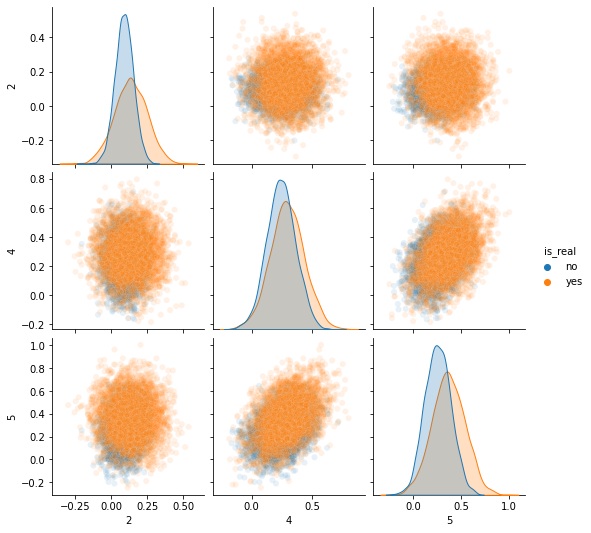

In [19]:
indices = [2, 4, 5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices]) # (3, 3)
fake_samples = fake_dist.sample((5000,)) # (5000, 3)
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(df, plot_kws={'alpha': 0.1}, hue='is_real')

Lastly, you can use your earlier `frechet_distance` function to calculate the FID and evaluate your GAN. You can see how similar/different the features of the generated images are to the features of the real images. 

In [80]:
# evaluate GAN, single digit is good
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

136.30043029785156
